In [4]:
import numpy as np
from scipy.fftpack import fft2, ifft2
from numpy.fft import fftshift, ifftshift
from PIL import Image
import matplotlib.pyplot as plt


# imagen host de 1614x1614, imagen a esconder de 143x143
imagen_host = np.array(Image.open("prueba2.jpg").convert('L'))

img1 = imagen_host.copy()
img3 = np.array(Image.open("img260.png").convert("L"))


# Ejercicio 1
Usar LSB para ocultar un mensaje, luego, decodificarlo

1. Importar una imagen host
2. Aplanar la imagen como array. Cada 8 bits tengo un pixel
3. Elegir un mensaje
4. Pasar mensaje a binario
6. Cada 8 bits en mi imagen, reemplazo el último bit por el del mensaje
7. Sigo iterando hasta encontrar '&' en mi mensaje

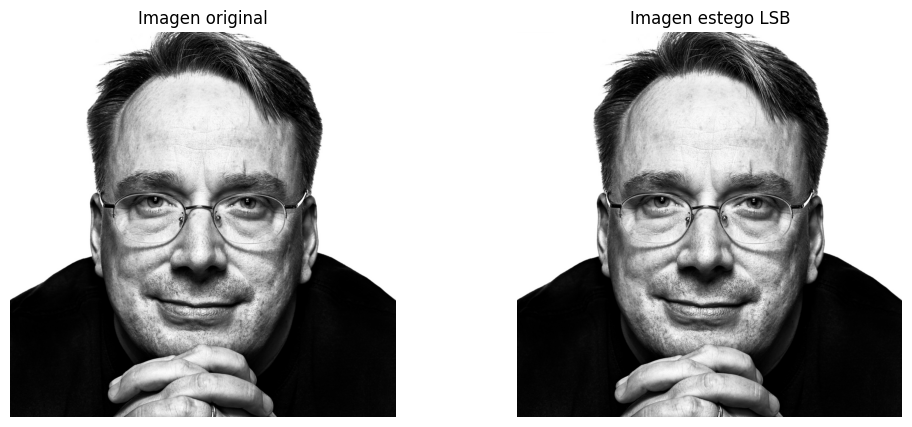

In [5]:
def texto_a_binario(msj):
    # mensaje -> ascii y ascii -> binario
    # fin de mensaje con &
    msj += '&'
    binario = ''
    
    # cada letra se pasa a ascii con ord() y luego a binario con format()
    for letra in msj:
        ascii = ord(letra)
        bin8 = format(ascii,'08b')
        # concateno resultado en array a retornar
        binario += bin8
        
    return binario

def LSB (host, msj):
    # flatten para recorrer la imagen como array (despues hacemos reshape)
    host = host.flatten()
    long_msj = len(msj)
    
    # si el mensaje entra en la imagen
    if (long_msj <= len(host)):
        for k in range(long_msj):
            val = host[k]
            
            # paso valor uint8 a bit
            val = bin(val)
            # val[:-1] me da todo el array excepto el último bit
            val_nuevo = val[:-1] + mensaje[k]
            host[k] = int(val_nuevo, 2)
            
    # si el mensaje es demasiado largo, informar
    else:
        print("El mensaje es demasiado largo")
        
    return host

msj = "YOU SHALL NOT PASS"
mensaje = texto_a_binario(msj)

# guardo el tamaño de la imagen para poder recuperarla después
x, y = img1.shape

img_LSB = LSB (img1,mensaje)
img_LSB = img_LSB.reshape((x,y))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img1, cmap = "gray")
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_LSB, cmap = "gray")
plt.title("Imagen estego LSB")
plt.axis('off')
plt.show()

# guardar como archivo estego > img_LSB es un array
img_guardar = Image.fromarray(img_LSB)
img_guardar.save("estego_ej1.png")

### DECODIFICADOR > EJERCICIO 1
1. Volcar la imagen en una matriz (matriz de bytes)
2. Pasar de matriz a array (array de bytes)
3. Recorro el array 

In [6]:
# DECODIFICADOR
def decodificar_mensaje(imagen):
    # como la imagen recibida es png, la cargo como matriz de bytes y la paso a array de bytes
    img = np.array(Image.open(imagen).convert('L'))
    img = img.flatten()
    
    msj_decodificado = ""
    k = 0
    fin = False

    while (not fin and k+8<=len(img)):
    # k va contando los bits que se leen. si a la img le quedan menos de 8, no los puede leer
        bits = ""
        for i in range(8):
            bits += str(img[k] & 1)
            k += 1
            
        # paso bits a byte, luego byte a char
        letra = chr(int(bits, 2))
        
        if letra == '&':
            fin = True
        else:
            msj_decodificado += letra
            
    return msj_decodificado

msg_oculto = decodificar_mensaje("estego_ej1.png")
print(f"Mensaje oculto: {msg_oculto}")

Mensaje oculto: YOU SHALL NOT PASS


# Ejercicio 2
Usar la TFT2 para ocultar una imagen, luego, decodificarla
PROP: P(m,n)=P(−m,−n)

1. Importar una imagen a ocultar (matriz de bytes con tamaño m,n)
2. Aplanar la matriz (array de bytes con tamaño m*n)
3. Pasar de bytes a bits (array de bits con tamaño 8*(m*n))
5. Aplicarle la transformada 2D de Fourier a imagen host
6. Hay que separar parte real de parte imaginaria para cada elemento i
7. Cambiar el signo b. Si bit_oc=0 y b<0 o si bit_oc=1 y b>=0, -b
8. Cuando terminé de ocultar el mensaje, obtengo matriz de reales e imaginarios en 1C
9. Para lograr una imagen real, si cambie en el primer cuadrante cambio en el conjugado
10. Para visualizar la imagen, aplico inversa de la tft2

### DECODIFICADOR > EJERCICIO 2

1. Recorro mi matriz transformada solo en primer cuadrante
2. Si el signo de la parte imaginaria es -1, guardo un 1. Si no, un 0
3. Itero hasta la longitud de mi secreto
4. Obtengo un array de bits
5. Paso este a un array de bytes
6. Hago reshape para obtener una matriz de bytes con el tamaño original del secreto
 

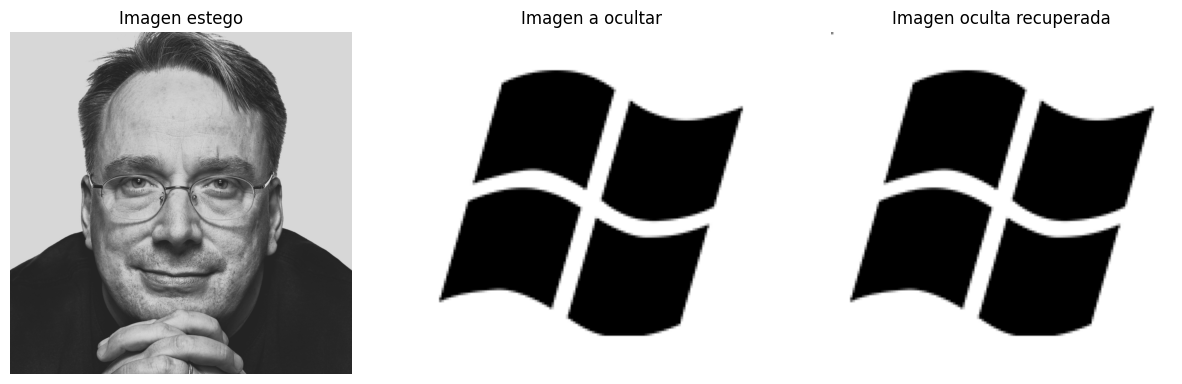

In [7]:
def bytes_a_bits (img):
    return np.unpackbits(img.astype(np.uint8)).astype(np.uint8)


def conjugado(fft_cuad1):
    m, n = fft_cuad1.shape
    cuad1_sim = fft_cuad1.copy()
    
    for i in range(m):
        for j in range(n):
            conj_i = (-i) % m
            conj_j = (-j) % n
            cuad1_sim[conj_i, conj_j] = np.conj(fft_cuad1[i, j])
            
    return cuad1_sim

def ocultar_img (host_fft, secreto):
    indx = 0
    m, n = host_fft.shape
    nueva_fft = host_fft.copy()

    for i in range(m//2):
        for j in range(n//2):
            if indx == len(secreto):
                break

            a = np.real(host_fft[i, j])
            b = np.imag(host_fft[i, j])
            bit = secreto[indx]


            if (bit == 0 and b < 0) or (bit == 1 and b >= 0):
                b = -b

            # guardo los cambios
            nueva_fft[i, j] = a + 1j * b
            
            # conjugado
            ci = (-i) % m
            cj = (-j) % n
            
            # guardo el conjugado
            nueva_fft[ci, cj] = a - 1j * b  

            indx += 1

    return nueva_fft

def decod_imagen(host_fft, num_bits):
    bits = []
    m, n = host_fft.shape
    indx = 0

    for i in range(m//2):
        for j in range(n//2):
            if indx == num_bits:
                break

            imag = np.imag(host_fft[i, j])
            if (imag>=0):
                bits.append(0)
            else:
                bits.append(1)

            indx += 1

    return np.packbits(bits)

# paso imagen a array de bits
secreto = bytes_a_bits(img3.flatten())

# aplico transformada 2D
host_fft = fftshift(fft2(img1))

# oculto la imagen dentro de host. devuelve matriz con comp reales e imag
estego_fft = ocultar_img (host_fft, secreto)

# recupero la imagen con inversa fft. paso frecuencias cercanas a cero con ifftshift
estego_img = np.real(ifft2(ifftshift(estego_fft)))

# guardo imagen estego
plt.imsave('estego.png', estego_img, cmap='gray')

# recupero imagen oculta
recuperado_bits = decod_imagen(estego_fft, len(secreto))
img_recuperada = recuperado_bits.reshape(img3.shape)

# PLOTEO
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(estego_img, cmap='gray')
plt.title("Imagen estego")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img3, cmap='gray')
plt.title("Imagen a ocultar")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_recuperada, cmap='gray')
plt.title("Imagen oculta recuperada")
plt.axis('off')



plt.tight_layout
plt.show()



# Ejercicio 3

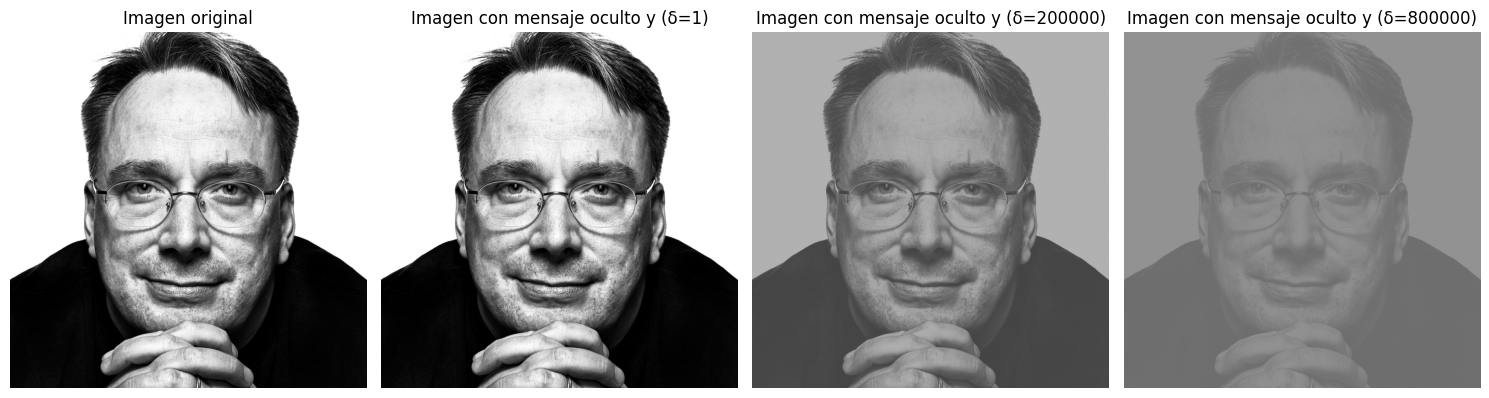

In [8]:
def img_a_bin(img):
    return np.unpackbits(img.astype(np.uint8)).astype(np.uint8)

def modificar_coeficientes(fft_img, mensaje, delta):
    fft_mod = fft_img.copy()
    fila, cols = fft_mod.shape
    index = 0
    total_bits = len(mensaje)
    
    for i in range(fila):
        for j in range(cols):
            if index >= total_bits:
                break
            
            # trabajo solo en el primer cuadrante y después hago el conjugado
            if (i < fila//2 and j < cols//2):
                # aislo parte real
                a = fft_mod[i, j].real
                
                # guardo el signo de a en signo_a
                if (a >= 0): signo_a = 1 
                else: signo_a= -1
                    
                # fórmula para q=abs(round(a/δ))
                q_a = np.abs(np.round(a / delta))
                
                if (index < total_bits):
                    bit = mensaje[index]
                    # si tengo que ocultar 1 y q par, q++
                    # si tengo que ocultar 0 y q impar, q++
                    if (bit == 1 and q_a % 2 == 0) or (bit == 0 and q_a % 2 == 1):
                        q_a += 1
                        
                    # a'=signo.q_a.delta    
                    a_nuevo = signo_a * q_a * delta
                    # como ya oculté un bit de mensaje, itero
                    index += 1
                else:
                    # si ya terminé de ocultar el mensaje, no modifico el dato orig.
                    a_nuevo = a
                
                
# tengo que volver a verificar el index, porque puede que al terminar de asignar el mensaje en la parte real me salga de rango
                
                if (index < total_bits):
                    # aislo la parte imaginaria
                    b = fft_mod[i, j].imag
                    
                    # guardo el signo de b en signo_b
                    if (b >= 0): signo_b = 1 
                    else: signo_b= -1
                        
                    # fórmula para q=abs(round(b/δ))
                    q_b = np.abs(np.round(b / delta))
                    
                    bit = mensaje[index]
                    
                    # si tengo que ocultar 1 y q par, q++
                    # si tengo que ocultar 0 y q impar, q++
                    if (bit == 1 and q_b % 2 == 0) or (bit == 0 and q_b % 2 == 1):
                        q_b += 1
                        
                    # b'=signo.q_b.delta  
                    b_nuevo = signo_b * q_b * delta
                    index += 1
                else:
                    b_nuevo = fft_mod[i, j].imag
                
                # si terminé de modificar, guardo el bit como a'+b'j
                fft_mod[i, j] = a_nuevo + 1j * b_nuevo
    
    
    return fft_mod

# <<< FIN DE FUNCIONES >>>

# convierto imagen a array con binarios
bits_msg = img_a_bin(img3)

# tft2 de la imagen portadora y aplicar shift, de lo contrario obtengo cruz oscura en medio
# shift agarra las frecuencias más cercanas a 0 y las deja cerca del centro
fft_img = fftshift(fft2(img1))

# delta muy alto vs delta cercano a 0
delta1 = 800000
delta2 = 200000
delta3 = 1

# CASO 1: DELTA MEDIANO
fft_mod1 = modificar_coeficientes(fft_img, bits_msg, delta1)
fft21 = conjugado (fft_mod1)
img_mod1 = (ifft2(ifftshift(fft21))).real

# CASO 2: DELTA GRANDE
fft_mod2 = modificar_coeficientes(fft_img, bits_msg, delta2)
fft22 = conjugado (fft_mod2)
img_mod2 = (ifft2(ifftshift(fft22))).real

# CASO 3: DELTA=1
fft_mod3 = modificar_coeficientes(fft_img, bits_msg, delta3)
fft23 = conjugado (fft_mod3)
img_mod3 = (ifft2(ifftshift(fft23))).real

# PLOTEO
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img1, cmap='gray')
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_mod3, cmap='gray')
plt.title(f"Imagen con mensaje oculto y (δ={delta3})")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_mod2, cmap='gray')
plt.title(f"Imagen con mensaje oculto y (δ={delta2})")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_mod1, cmap='gray')
plt.title(f"Imagen con mensaje oculto y (δ={delta1})")
plt.axis('off')

plt.tight_layout()
plt.show()

# NOTA: A MEDIDA QUE SE AUMENTA DELTA SE VA PERDIENDO INFORMACIÓN, SE ELIMINAN FRECUENCIAS ALTAS
# SI DELTA ES CERCANO A 0, LOS COEFICIENTES NO CAMBIAN MUCHO Y SE PARECE DEMASIADO A IMAGEN ORIGINAL


# Codificador de texto con método tft2 delta para preguntas grupales

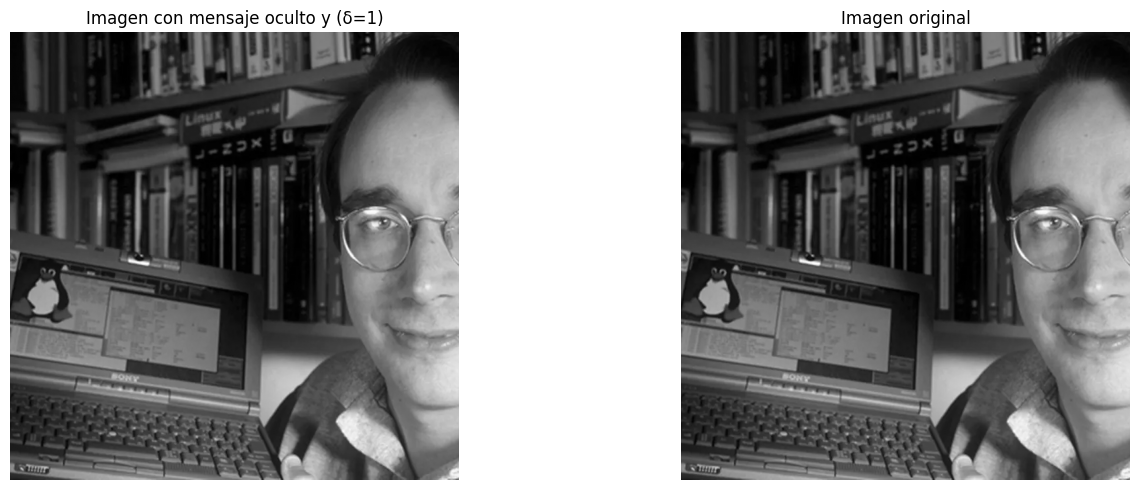

In [ ]:
def textoaBinario(texto):
    lista_bytes = []
    for c in texto:
        ascii = ord(c)
        lista_bytes.append(ascii)
        
    bytes_array = np.array(lista_bytes,dtype=np.uint8)
    bits_array = np.unpackbits(bytes_array)
    
    return bits_array

def bits_a_texto(bits_array):
    bits_validos = bits_array[:len(bits_array) // 8 * 8]
    mensaje_bytes = np.packbits(bits_validos)
    return mensaje_bytes.tobytes().decode('utf-8', errors='replace')

def extraer_bits(matriz_fft, longitud_mensaje, delta=1):
    bits = []
    filas, cols = matriz_fft.shape
    
    for i in range(filas//2):
        for j in range(cols//2):
            
            if(len(bits) >= longitud_mensaje):
                break
            
            real = matriz_fft[i, j].real
            imag = matriz_fft[i, j].imag
                      
            q_real = round(abs(real) / delta)
            bits.append(q_real % 2)
                
            if(len(bits) >= longitud_mensaje):
                break
            
            q_imag = round(abs(imag) / delta)
            bits.append(q_imag % 2)
            
           # :hastaEstaLongitud
    Bits = np.array(bits[:longitud_mensaje],dtype=np.uint8)
    return Bits 

# OCULTAMOS
imhost = np.array(Image.open("elrocholinus.png").convert("L"))
txt = "Que metodo usaron para codificar y decodificar el ejercicio 2?&"
bits_mensaje = textoaBinario(txt)
long_pregunta = len(bits_mensaje)
delta = 1

host_tft = fftshift(fft2(imhost))

# estego_txt es una matriz con componentes imaginarias que tiene el mensaje oculto
estego_txt = modificar_coeficientes(host_tft,bits_mensaje,delta)
estego_plot = (ifft2(ifftshift(estego_txt))).real

#plt.imsave('preguntas.svg', estego_txt, cmap='gray')
np.save("preguntas.npy", estego_txt)


# PLOTEO
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(estego_plot, cmap='gray')
plt.title(f"Imagen con mensaje oculto y (δ={delta})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imhost, cmap='gray')
plt.title("Imagen original")
plt.axis('off')

plt.tight_layout()
plt.show()

# Decodificador de texto para las preguntas grupales

In [10]:
# DECODIFICAMOS

bits_recuperados = extraer_bits(estego_txt,long_pregunta, delta)
mensaje_recuperado = bits_a_texto(bits_recuperados)

print("Mensaje original: ", txt)
print("Mensaje recuperado: ", mensaje_recuperado)

Mensaje original:  Que metodo usaron para codificar y decodificar el ejercicio 2?&
Mensaje recuperado:  Que metodo usaron para codificar y decodificar el ejercicio 2?&
